## PS 3 - Week 14 - Multivariate Regression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

We are going to return to the example of the Affordable Care Act, and look at the political implications of the bill. Recall that the Democrats lost 63 seats in the House in the 2010 midterms after the passing of the ACA. Let's explore if there is evidence that this was driven by votes on the bill.

First, we are going to load up some data on these house elections. The data come from <a href="https://journals.sagepub.com/doi/abs/10.1177/1532673X11433768">this paper</a>, and are stored in Stata format. We can read this in using the `read_stata` function from the pandas library.

In [2]:
hcr_mid = pd.read_stata("hcr_midterm.dta")
hcr_mid

,dem,rep,rpt,state,cd,party,hcr_yes,obama,dem_n,hcr_obama
0,31%,69%,100%,AK,1,R,0,38,31.0,0.0
1,,83%,100%,AL,1,R,0,39,NaN,0.0
2,49%,51%,100%,AL,2,D,0,36,49.0,0.0
3,41%,59%,100%,AL,3,R,0,43,41.0,0.0
4,,Unc.,,AL,4,R,0,23,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
429,45%,55%,99%,WI,8,D,1,54,45.0,54.0
430,50%,50%,100%,WV,1,D,1,42,50.0,42.0
431,30%,68%,100%,WV,2,R,0,44,30.0,0.0
432,55%,45%,100%,WV,3,D,1,42,55.0,42.0


How someone voted on the ACA is stored in the variable `hcr_yes`, and their whether they are a Republican or Democrat is in `party`. Let's look at the relationship between these two.

In [3]:
pd.crosstab(hcr_mid["hcr_yes"], hcr_mid["party"])

party,D,R
hcr_yes,,
0,39,176
1,218,1


Only <a href="https://en.wikipedia.org/wiki/Joseph_Cao">one Republican</a> voted for the bill, and 39 democrats voted against it. The main comparison we want to make is whether the Democrats who voted for the bill did better or worse in the 2010 midterms than those who voted against it.

To do this, let's first subset the data to districts with democratic incumbents who ran in competitive elections.

In [4]:
hcr_mid = hcr_mid[(hcr_mid["dem_n"] > 0) & (hcr_mid["party"]=="D")]
hcr_mid

,dem,rep,rpt,state,cd,party,hcr_yes,obama,dem_n,hcr_obama
2,49%,51%,100%,AL,2,D,0,36,49.0,0.0
5,42%,58%,100%,AL,5,D,0,38,42.0,0.0
7,72%,28%,99%,AL,7,D,0,72,72.0,0.0
8,43%,52%,99%,AR,1,D,1,38,43.0,38.0
9,38%,58%,99%,AR,2,D,1,44,38.0,44.0
...,...,...,...,...,...,...,...,...,...,...
425,69%,30%,100%,WI,4,D,1,75,69.0,75.0
428,44%,52%,100%,WI,7,D,1,56,44.0,56.0
429,45%,55%,99%,WI,8,D,1,54,45.0,54.0
430,50%,50%,100%,WV,1,D,1,42,50.0,42.0


The `dem_n` variable is the democratic vote share in the 2010 midterms. Let's look at the distribution:

In [5]:
np.mean(hcr_mid["dem_n"])

58.164707

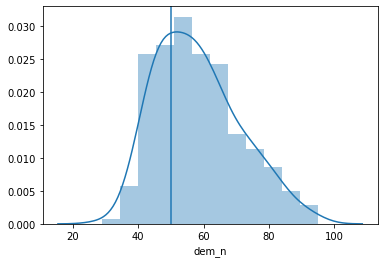

In [6]:
sns.distplot(hcr_mid["dem_n"])
plt.axvline(50)

The average D running for re-election recieved almos 60% of the vote, but quite a few lost re-election.

Now let's compare the performance of those who voted for and against the bill. First, let's create separate data files for the Y and N voters.

In [7]:
hcr_mid_y = hcr_mid[hcr_mid["hcr_yes"] == 1]
hcr_mid_n = hcr_mid[hcr_mid["hcr_yes"] == 0]

And take the averages

In [8]:
mean_y = np.mean(hcr_mid_y["dem_n"])
mean_y

60.203705

In [9]:
mean_n = np.mean(hcr_mid_n["dem_n"])
mean_n

46.871796

Here is the raw difference of means:

In [10]:
dom = mean_y - mean_n
dom

13.331909

This indicates those who voted Y did about 13% better, which i a huge difference! Let's do a t-test to see if this is statistically significant

In [11]:
t_model = stats.ttest_ind(hcr_mid_y["dem_n"], hcr_mid_n["dem_n"])
t_model

Ttest_indResult(statistic=6.402170869398653, pvalue=7.394894688619953e-10)

With a t-statistic above 6, this is easily statistically significant at the p < .01 level.

As discussed in the lecture, we can also test this with a bivariate regression where our IV is the vote and the DV is the vote share.

In [12]:
ols_model = stats.linregress(hcr_mid["hcr_yes"], hcr_mid["dem_n"])
ols_model

LinregressResult(slope=13.3319088319088, intercept=46.87179617327985, rvalue=0.3733899262686957, pvalue=7.394906089046733e-10, stderr=2.0824044958136767)

The "slope" is equal to the difference of means, and the intercept is the mean of those who voted N. (Why?) Note we also get the same p value as the difference of means test. We can also check the t value is the same by dividing the slope by the standard error:

In [13]:
ols_model[0]/ols_model[4]

6.402170595919456

Now let's think about some reasons why this relatinship might not be causal. A major confounding variable is that those who voted Yes likely represent more liberal districts, making their re-election easier. To check this, we will look also bring Obama's 2008 vote share into our analysis.

First, let's look at the relationship between Obama's 2008 vote share and the House members 2010 vote share.

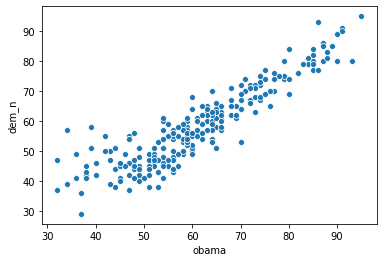

In [14]:
sns.scatterplot(x='obama', y='dem_n', data=hcr_mid)

As we can see, there is a strong positive relationship. This shouldn't surprise us: most people vote for the same party consistently.

Now let's do a version of the same plot where we plot the Y votes with green dots and the N votes with orange dots.

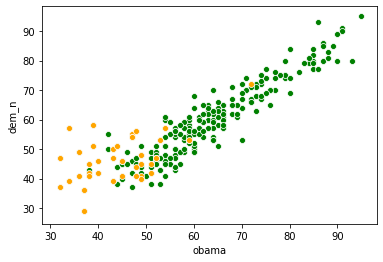

In [15]:
sns.scatterplot(x='obama', y='dem_n', data=hcr_mid, color="green")
sns.scatterplot(x='obama', y='dem_n', data=hcr_mid_n, color="orange")

Note the orange dots are to the left, meaning those who voted N where generally in more moderate/conservative districts.

We can visualize the difference in average vote share by adding horizontal lines:

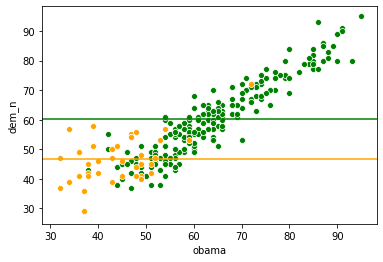

In [16]:
sns.scatterplot(x='obama', y='dem_n', data=hcr_mid_y, color="green")
sns.scatterplot(x='obama', y='dem_n', data=hcr_mid_n, color="orange")
plt.axhline(mean_y, color='green')
plt.axhline(mean_n, color='orange')

And we can look at the relationship between the vote and how liberal the district was by plotting the average Obama vote share among the Y and N districts:

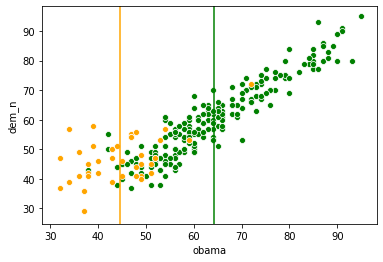

In [37]:
sns.scatterplot(x='obama', y='dem_n', data=hcr_mid_y, color="green")
sns.scatterplot(x='obama', y='dem_n', data=hcr_mid_n, color="orange")
plt.axvline(np.mean(hcr_mid_y["obama"]), color='green')
plt.axvline(np.mean(hcr_mid_n["obama"]), color='orange')

Combining what we know so far: districts where members voted Y did much better in the election, but these were also just more liberal ("safe") disticts. 

Now lets use mulitvariate regression to "control" for Obama vote share.

First, let's re-do our bivariate analysis using the `OLS` function from the statsmodels.formula.api library. 

In [39]:
ols_biv = smf.ols('dem_n ~ hcr_yes', data=hcr_mid).fit()
ols_biv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  dem_n   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     40.99
Date:                Mon, 16 Nov 2020   Prob (F-statistic):           7.39e-10
Time:                        15:40:27   Log-Likelihood:                -993.81
No. Observations:                 255   AIC:                             1992.
Df Residuals:                     253   BIC:                             1999.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     46.8718      1.917     24.456      0.000      43.097      50.646
hcr_yes       13.3319      2.082      6.402      0.000       9.231      17.433
==============================================================================
Omnibus:                       10.265   Durbin-Watson:                   1.412
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.898
Skew:                           0.498   Prob(JB):                      0.00430
Kurtosis:                       2.817   Cond. No.                         4.93
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now let's do the same, adding the Obama vote share

In [40]:
ols_biv = smf.ols('dem_n ~ hcr_yes + obama', data=hcr_mid).fit()
ols_biv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  dem_n   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     657.5
Date:                Mon, 16 Nov 2020   Prob (F-statistic):          9.98e-101
Time:                        15:40:29   Log-Likelihood:                -779.96
No. Observations:                 255   AIC:                             1566.
Df Residuals:                     252   BIC:                             1577.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4892      1.526      2.943      0.004       1.485       7.494
hcr_yes       -5.3155      1.063     -4.999      0.000      -7.410      -3.221
obama          0.9510      0.029     33.113      0.000       0.894       1.008
==============================================================================
Omnibus:                        9.991   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               12.235
Skew:                           0.331   Prob(JB):                      0.00220
Kurtosis:                       3.844   Cond. No.                         294.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now there is a negative coefficient on `hcr_yes`!

To make a plot, we can pull out the coefficients by adding a `.params` after the name of our fitted model.

In [21]:
ols_biv.params

Intercept    4.489197
hcr_yes     -5.315472
obama        0.951048
dtype: float64

Let's overlay the predicted value for Y and N votes as a function of Obama vote share.

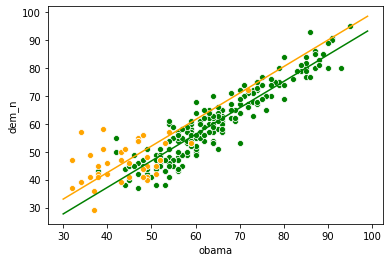

In [36]:
sns.scatterplot(x='obama', y='dem_n', data=hcr_mid_y, color="green")
sns.scatterplot(x='obama', y='dem_n', data=hcr_mid_n, color="orange")
xrange = np.arange(30, 100)
plt.plot(xrange, ols_biv.params[0] + xrange*ols_biv.params[2], color="orange")
plt.plot(xrange, ols_biv.params[0] + ols_biv.params[1] + xrange*ols_biv.params[2], color="green")

The takeaway is that the main drive of how well D's running did in 2010 is how well Obama did in 2008. The fact that those who voted for the ACA did better overall is hence misleading!